# LIGHTGBM 

Objetivo: Entrenar modelo LightGBM con hiperparámetros por defecto para comparar con el baseline (Regresión Logística) y XGBoost.

Fases temporales:
- T0 (Matrícula)          : Variables disponibles al momento de inscripción
- T1 (Fin 1er Semestre)   : T0 + variables académicas del 1er semestre, información de matrícula y deudor
- T2 (Fin 2do Semestre)   : T1 + variables académicas del 2do semestre

Preprocesamiento específico para LightGBM:
- No requiere escalado
- Label Encoding para categóricas
- Target Encoding para 'course'

Pipeline:
1. Carga de datos preprocesados
2. Definición de variables por fase temporal
3. Split estratificado (80/20)
4. Preprocesamiento específico para LightGBM
5. Entrenamiento con Cross-Validation 5-fold
6. Evaluación en test set
7. Comparación de resultados por fase

## 0. Librerias y configuración

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder

# Modelo
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Target Encoding
from category_encoders import TargetEncoder

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorio de salida
OUTPUT_DIR = "../outputs/figures/modelado/LightGBM/"
OUTPUT_DIR_REPORTES = "../outputs/models/LightGBM/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_REPORTES, exist_ok=True)

# mlflow
import mlflow
import mlflow.sklearn

## 1. Carga de datos preprocesados

In [20]:
# Cargar dataset preprocesado
df = pd.read_csv('../data/processed/preprocessed_data.csv')

print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
print(df['target_binario'].value_counts())
print(f"\nRatio de desbalance: {df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]:.2f}:1")

df.head()

Dataset cargado: 4424 filas x 38 columnas
target_binario
0    3003
1    1421
Name: count, dtype: int64

Ratio de desbalance: 2.11:1


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,is_single,application_mode_risk,is_over_23_entry,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,has_unknown_parent_info,target_binario
0,5,171,1,122.0000,127.3000,1,0,0,1,1,0,20,0,0,0,0,0,0.0000,0,0,0,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,0,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,0,1
1,1,9254,1,160.0000,142.5000,1,0,0,0,1,0,19,0,0,6,6,6,14.0000,0,0,6,6,6,13.6667,0,13.9000,-0.3000,0.7900,1,Bajo_Riesgo,0,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0,0
2,5,9070,1,122.0000,124.8000,1,0,0,0,1,0,19,0,0,6,0,0,0.0000,0,0,6,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,0,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,0,1
3,2,9773,1,122.0000,119.6000,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4000,0,9.4000,-0.8000,-3.1200,1,Bajo_Riesgo,0,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0,0
4,1,8014,0,100.0000,141.5000,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0000,0,13.9000,-0.3000,0.7900,0,Alto_Riesgo,1,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0,0


## 2. Definición de variables por fase temporal (T0, T1, T2)

In [21]:
# TARGET
TARGET = 'target_binario'

# -----------------------------------------------------------------------------
# VARIABLES BINARIAS (no requieren encoding, ya son 0/1)
# -----------------------------------------------------------------------------
VARS_BINARIAS_T0 = [
    'daytimeevening_attendance',
    'displaced',
    'educational_special_needs',
    'gender',
    'scholarship_holder',
    'international',
    'is_single'
]

VARS_BINARIAS_T1 = [
    'debtor',
    'tuition_fees_up_to_date'
]


# -----------------------------------------------------------------------------
# VARIABLES NUMÉRICAS (NO requieren escalado para LightGBM)
# -----------------------------------------------------------------------------
VARS_NUMERICAS_T0 = [
    'age_at_enrollment',
    'admission_grade',
    'previous_qualification_grade'
]

VARS_NUMERICAS_T1 = [
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

VARS_NUMERICAS_T2 = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS AGRUPADAS (requieren Label Encoding para LightGBM)
# -----------------------------------------------------------------------------
VARS_CATEGORICAS_AGRUPADAS_T0 = [
    'application_mode_risk',
    'previous_qualification_risk',
    'mothers_qualification_level',
    'fathers_qualification_level',
    'mothers_occupation_level',
    'fathers_occupation_level'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS PARA TARGET ENCODING
# -----------------------------------------------------------------------------
VARS_TARGET_ENCODING_T0 = ['course']

# -----------------------------------------------------------------------------
# VARIABLE ORDINAL (se trata como numérica)
# -----------------------------------------------------------------------------
VARS_ORDINALES_T0 = ['application_order']

# =============================================================================
# COMPOSICIÓN DE VARIABLES POR FASE TEMPORAL
# =============================================================================

# T0: Variables disponibles al momento de matrícula
VARS_T0 = (
    VARS_BINARIAS_T0 +
    VARS_NUMERICAS_T0 +
    VARS_CATEGORICAS_AGRUPADAS_T0 +
    VARS_TARGET_ENCODING_T0 +
    VARS_ORDINALES_T0
)

# T1: T0 + variables del 1er semestre
VARS_T1 = (
    VARS_T0 +
    VARS_BINARIAS_T1 +
    VARS_NUMERICAS_T1
)

# T2: T1 + variables del 2do semestre
VARS_T2 = (
    VARS_T1 +
    VARS_NUMERICAS_T2
)

print("================================================================================")
print("  VARIABLES POR FASE TEMPORAL")
print("================================================================================")
print(f"\n T0 (Matrícula): {len(VARS_T0)} variables")
print(f" T1 (Fin 1er Sem): {len(VARS_T1)} variables (+{len(VARS_T1) - len(VARS_T0)})")
print(f" T2 (Fin 2do Sem): {len(VARS_T2)} variables (+{len(VARS_T2) - len(VARS_T1)})")

  VARIABLES POR FASE TEMPORAL

 T0 (Matrícula): 18 variables
 T1 (Fin 1er Sem): 29 variables (+11)
 T2 (Fin 2do Sem): 35 variables (+6)


## 3. Split TRAIN/TEST 

In [22]:
# Split se hace en totalidad del dataste, posteriormente se seleccionan las variables según la fase temporal para entrenemiento y evaluación

X = df[VARS_T2].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("================================================================================")
print("  SPLIT TRAIN/TEST")
print("================================================================================")
print(f"\nTrain: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nDistribución del target en Train:")
print(y_train.value_counts())
print(f"Ratio de desbalance:: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

print(f"\nDistribución del target en Test:")
print(y_test.value_counts())
print(f"Ratio de desbalance:: {y_test.value_counts()[0] / y_test.value_counts()[1]:.2f}:1")

  SPLIT TRAIN/TEST

Train: 3539 (80.0%)
Test:  885 (20.0%)

Distribución del target en Train:
target_binario
0    2402
1    1137
Name: count, dtype: int64
Ratio de desbalance:: 2.11:1

Distribución del target en Test:
target_binario
0    601
1    284
Name: count, dtype: int64
Ratio de desbalance:: 2.12:1


## 4. Funciones de preprocesamiento para LIGHTGBM

In [23]:
def obtiene_variables_por_fase(fase):
    # Retorna las listas de variables según la fase temporal, retorna diccionario con variables de la fase
    if fase == 'T0':
        return {
            'binarias': VARS_BINARIAS_T0,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T0
        }
    elif fase == 'T1':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T1
        }
    elif fase == 'T2':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1 + VARS_NUMERICAS_T2,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T2
        }
    else:
        raise ValueError(f"Fase no válida: {fase}. Usar 'T0', 'T1', o 'T2'")


def preprocesamiento_lightgbm(X_train, X_test, y_train, fase):
    # Preprocesa los datos para LightGBM    
    variables_fase = obtiene_variables_por_fase(fase)
    
    # Seleccionar solo las variables de la fase
    X_train_fase = X_train[variables_fase['all']].copy()
    X_test_fase = X_test[variables_fase['all']].copy()
    
    # Diccionario para guardar encoders
    label_encoders = {}
    
    # -------------------------------------------------------------------------
    # 1. TARGET ENCODING para 'course' 
    # -------------------------------------------------------------------------
    te = TargetEncoder(cols=variables_fase['categoricas_te'], smoothing=0.3)
    
    for col in variables_fase['categoricas_te']:
        X_train_fase[col + '_encoded'] = te.fit_transform(X_train_fase[[col]], y_train)[col]
        X_test_fase[col + '_encoded'] = te.transform(X_test_fase[[col]])[col]
        # Eliminar columna original
        X_train_fase = X_train_fase.drop(columns=[col])
        X_test_fase = X_test_fase.drop(columns=[col])
    
    # -------------------------------------------------------------------------
    # 2. LABEL ENCODING para categóricas agrupadas
    # -------------------------------------------------------------------------
    for col in variables_fase['categoricas_le']:
        le = LabelEncoder()
        X_train_fase[col] = le.fit_transform(X_train_fase[col].astype(str))
        X_test_fase[col] = le.transform(X_test_fase[col].astype(str))
        label_encoders[col] = le
    
    # -------------------------------------------------------------------------
    # Guardar información
    # -------------------------------------------------------------------------
    variables = X_train_fase.columns.tolist()
    preprocessors = {
        'target_encoder': te,
        'label_encoders': label_encoders,
        'feature_names': variables
    }
    
    return X_train_fase, X_test_fase, variables, preprocessors

## 5. Funciones entrenamiento

In [24]:
# Entrenamiento con parámetros por defecto
def entrena_lightgbm(X_train, y_train, fase, cv_folds=5):
    """Entrena y evalúa LightGBM con Cross-Validation."""
    
    mlflow.end_run()
         
    print("================================================================================")
    print(f"  ENTRENAMIENTO LIGHTGBM - FASE {fase}")
    print("================================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros: {X_train.shape[0]}")
    
    # -------------------------------------------------------------------------
    # Calcular scale_pos_weight para desbalance
    # -------------------------------------------------------------------------
    n_neg = (y_train == 0).sum()
    n_pos = (y_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    print(f"\nscale_pos_weight: {scale_pos_weight:.2f}")
    
    print(f"\nHiperparámetros (por defecto):")
    print(f"   • n_estimators: 100")
    print(f"   • max_depth: -1 (sin límite)")
    print(f"   • num_leaves: 31")
    print(f"   • learning_rate: 0.1")
    print(f"   • min_child_samples: 20")
    
    # -------------------------------------------------------------------------
    # Cross-Validation con loop manual
    # -------------------------------------------------------------------------
    print(f"\nCross-Validation ({cv_folds}-fold):")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # Almacenar resultados por fold
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }

    train_losses = []
    val_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Crear y entrenar modelo
        modelo_lgb = LGBMClassifier(
            n_estimators=100,
            max_depth=-1,
            num_leaves=31,
            learning_rate=0.1,
            subsample=1.0,
            colsample_bytree=1.0,
            min_child_samples=20,
            reg_alpha=0,
            reg_lambda=0,
            scale_pos_weight=scale_pos_weight,
            objective='binary',
            #metric='auc',
            metric='binary_logloss',
            boosting_type='gbdt',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        )
        #modelo_lgb.fit(X_fold_train, y_fold_train)
        modelo_lgb.fit(
            X_fold_train,
            y_fold_train,
            eval_set=[(X_fold_train, y_fold_train),
                  (X_fold_val, y_fold_val)],
            eval_names=['train', 'validation'],
            callbacks=[lgb.log_evaluation(period=0)]  # Silenciar logs
        )
        # Obtiene historial de métricas
        train_loss = modelo_lgb.evals_result_['train']['binary_logloss']
        val_loss = modelo_lgb.evals_result_['validation']['binary_logloss']
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Predicciones
        y_train_pred = modelo_lgb.predict(X_fold_train)
        y_train_proba = modelo_lgb.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_lgb.predict(X_fold_val)
        y_val_proba = modelo_lgb.predict_proba(X_fold_val)[:, 1]
        
        # Métricas Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Métricas Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    
    # Calcular longitud mínima
    min_len = min(len(l) for l in train_losses)
    
    # Recorta y promedia
    train_losses_array = np.array([l[:min_len] for l in train_losses])
    val_losses_array = np.array([l[:min_len] for l in val_losses])
    
    train_mean = train_losses_array.mean(axis=0)
    train_std = train_losses_array.std(axis=0)
    val_mean = val_losses_array.mean(axis=0)
    val_std = val_losses_array.std(axis=0)
    
    iterations = range(1, min_len + 1)
    
    # =========================================================================
    # GRAFICAR
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(iterations, train_mean, label='Train Loss', color='#3498DB', linewidth=2)
    ax.fill_between(iterations, train_mean - train_std, train_mean + train_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(iterations, val_mean, label='Validation Loss', color='#E74C3C', linewidth=2)
    ax.fill_between(iterations, val_mean - val_std, val_mean + val_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Iterations (n_estimators)', fontsize=12)
    ax.set_ylabel('Binary Logloss', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - LightGBM {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Sin mptimizar', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar punto de mejor validación
    best_iter = np.argmin(val_mean)
    ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_iter], [val_mean[best_iter]], color='green', s=100, zorder=5,
               label=f'Mejor iteración: {best_iter}')
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_lightgbm_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_final = train_mean[-1] - val_mean[-1]
    
    print(f"\n Resumen:")
    print(f"   Mejor iteración: {best_iter}")
    print(f"   Train Loss final: {train_mean[-1]:.4f}")
    print(f"   Val Loss final: {val_mean[-1]:.4f}")
    print(f"   Val Loss mínimo: {val_mean[best_iter]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")



    # Convertir a numpy arrays
    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # -------------------------------------------------------------------------
    # Resultados por fold
    # -------------------------------------------------------------------------
    print("\n Resultados por fold:")
    for i in range(cv_folds):
        print(f"\n  Fold {i+1}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_score = cv_results[f'train_{metric}'][i]
            val_score = cv_results[f'test_{metric}'][i]
            print(f"    {metric:<10} | Train: {train_score:.4f} | Val: {val_score:.4f}")

    
    mlflow.set_experiment("TFM_Dropout_Prediction")
    with mlflow.start_run(run_name=f"LightGBM_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Params por default')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_lgb.get_params())

        # -------------------------------------------------------------------------
        # Resumen CV (media ± std)
        # -------------------------------------------------------------------------
        print(f"\n Resumen Cross-Validation:")
        print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12}")
        print(f"   {'-'*60}")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_mean = cv_results[f'train_{metric}'].mean()
            train_std = cv_results[f'train_{metric}'].std()
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
            print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>12.4f} {val_mean:>12.4f} {val_std:>12.4f}")
    
    
    # -------------------------------------------------------------------------
    # Retornar resultados
    # -------------------------------------------------------------------------
    results = {
        'phase': fase,
        'model': modelo_lgb,
        'n_features': X_train.shape[1],
        'cv_results': cv_results
    }
    
    return results



def resumen_cv(cv_results, fase, modelo):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    summary = {
        'modelo': modelo,
        'fase': fase
    }
    
    # -------------------------
    # Métricas de VALIDACIÓN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_val_mean'] = cv_results[f'test_{metric}'].mean()
        summary[f'{metric}_val_std']  = cv_results[f'test_{metric}'].std()
        

    # -------------------------
    # Métricas de TRAIN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_train_mean'] = cv_results[f'train_{metric}'].mean()
        summary[f'{metric}_train_std']  = cv_results[f'train_{metric}'].std()


    return pd.DataFrame([summary])


In [25]:
# OPTUNA CON CURVA DE FUNCION DE COSTE
import optuna

def entrena_lightgbm_con_optuna(X_train, y_train, fase, n_trials=50, cv_folds=5):
    """
    Entrena LigthGBM con optimización Optuna.
    Optimiza F1-score de clase Dropout (1) 
    """

    print("==========================================================================")
    print(f"  OPTIMIZACIÓN LigthGBM CON OPTUNA - FASE {fase}")
    print("==========================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros en train: {X_train.shape[0]}")
    print(f"Trials Optuna: {n_trials}")
    print(f"Métrica a optimizar: F1-score (clase Dropout)")

    # -------------------------------------------------------------------------
    # Calcular scale_pos_weight para desbalance
    # -------------------------------------------------------------------------
    n_neg = (y_train == 0).sum()
    n_pos = (y_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    print(f"\nscale_pos_weight: {scale_pos_weight:.2f}")

    
    # =========================================================================
    # FUNCIÓN OBJETIVO PARA OPTUNA
    # =========================================================================
    def objective(trial):
        
        # Hiperparámetros a optimizar
        params = {
            #"n_estimators": trial.suggest_int("n_estimators", 200, 1200),
            "n_estimators": trial.suggest_int("n_estimators", 10, 30),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 150),
            "max_depth": trial.suggest_int("max_depth", -1, 15),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 5.0)
        }
        
        # -------------------------------------------------------------------------
        # Cross-Validation
        # -------------------------------------------------------------------------
        print(f"\nCross-Validation ({cv_folds}-fold):")

        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
        scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train = X_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            try:
                modelo_lgb_opt_cv = LGBMClassifier(**params) 
                modelo_lgb_opt_cv.fit(X_fold_train, y_fold_train)
                y_pred = modelo_lgb_opt_cv.predict(X_fold_val)
                
                # F1-score de clase 1 (Dropout)
                f1 = f1_score(y_fold_val, y_pred, pos_label=1)
                scores.append(f1)
                
            except Exception:
                return 0.0
        
        return np.mean(scores)

        
    # =========================================================================
    # EJECUTAR OPTIMIZACIÓN
    # =========================================================================
    print(f"\nProceso de optimización")
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'F1-socre_{fase}',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # =========================================================================
    # MEJORES HIPERPARÁMETROS
    # =========================================================================
    best_params = study.best_params
    best_f1_score = study.best_value
    
    
    print(f"\n{'='*70}")
    print(f"  MEJORES HIPERPARÁMETROS")
    print(f"{'='*70}")
    print(f"  Mejor F1-score (CV): {best_f1_score:.4f}")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # =========================================================================
    # EVALUACIÓN FINAL CON MEJORES PARAMS
    # =========================================================================
    final_params = {
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'num_leaves' : best_params['num_leaves'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],        
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_samples': best_params['min_child_samples'],
        'reg_alpha': best_params.get('reg_alpha', 0),
        'reg_lambda': best_params.get('reg_lambda', 1),
        'scale_pos_weight': best_params['scale_pos_weight'],
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
       
    # CV final con todas las métricas
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    all_train_losses = []
    all_val_losses = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        modelo_lgb_opt = LGBMClassifier(**final_params, verbosity=-1)
        modelo_lgb_opt.fit(
            X_fold_train,
            y_fold_train,
            eval_set=[(X_fold_train, y_fold_train),
                  (X_fold_val, y_fold_val)],
            eval_names=['train', 'validation'],
            callbacks=[lgb.log_evaluation(period=0)]  # Silenciar logs
        )
        # Obtener historial de métricas
        train_loss = modelo_lgb_opt.evals_result_['train']['binary_logloss']
        val_loss = modelo_lgb_opt.evals_result_['validation']['binary_logloss']
        
        all_train_losses.append(train_loss)
        all_val_losses.append(val_loss)
        
        y_train_pred = modelo_lgb_opt.predict(X_fold_train)
        y_train_proba = modelo_lgb_opt.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_lgb_opt.predict(X_fold_val)
        y_val_proba = modelo_lgb_opt.predict_proba(X_fold_val)[:, 1]
        
        # Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    

    # Calcular longitud mínima
    min_len = min(len(l) for l in all_train_losses)
    
    # Recortar y promediar
    train_losses_array = np.array([l[:min_len] for l in all_train_losses])
    val_losses_array = np.array([l[:min_len] for l in all_val_losses])
    
    train_mean = train_losses_array.mean(axis=0)
    train_std = train_losses_array.std(axis=0)
    val_mean = val_losses_array.mean(axis=0)
    val_std = val_losses_array.std(axis=0)
    
    iterations = range(1, min_len + 1)
    
    # =========================================================================
    # GRAFICAR
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(iterations, train_mean, label='Train Loss', color='#3498DB', linewidth=2)
    ax.fill_between(iterations, train_mean - train_std, train_mean + train_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(iterations, val_mean, label='Validation Loss', color='#E74C3C', linewidth=2)
    ax.fill_between(iterations, val_mean - val_std, val_mean + val_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Iterations (n_estimators)', fontsize=12)
    ax.set_ylabel('Binary Logloss', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - LightGBM {fase}\n(Media ± Std de {cv_folds}-Fold CV)- Optimizado', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar punto de mejor validación
    best_iter = np.argmin(val_mean)
    ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_iter], [val_mean[best_iter]], color='green', s=100, zorder=5,
               label=f'Mejor iteración: {best_iter}')
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_lightgbm_opt_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_final = train_mean[-1] - val_mean[-1]
    
    print(f"\n Resumen:")
    print(f"   Mejor iteración: {best_iter}")
    print(f"   Train Loss final: {train_mean[-1]:.4f}")
    print(f"   Val Loss final: {val_mean[-1]:.4f}")
    print(f"   Val Loss mínimo: {val_mean[best_iter]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")


    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # =========================================================================
    # RESUMEN CV
    # =========================================================================
    print(f"\n{'='*70}")
    print(f"  RESUMEN CROSS-VALIDATION (Optimizado)")
    print(f"{'='*70}")
    print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>10} {'Val Mean':>12} {'Val Std':>10}")
    print(f"   {'-'*60}")
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        val_mean = cv_results[f'test_{metric}'].mean()
        val_std = cv_results[f'test_{metric}'].std()
        marker = "****" if metric == 'f1' else ""

        print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>10.4f} {val_mean:>12.4f} {val_std:>10.4f}{marker}")


    with mlflow.start_run(run_name=f"Optuna_LightGBM_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Baseline - Optimizado_Optuna')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_lgb_opt.get_params())
        mlflow.log_param("n_trials", n_trials)
        mlflow.log_param("cv_folds", cv_folds)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_metric("optuna_best_f1_cv", best_f1_score)
    
    
    # =========================================================================
    # MODELO FINAL PARA Entrenamiento previo a la evaluacion
    # =========================================================================
        #model_final_lgb = LGBMClassifier(**final_params)
        #model_final_lgb.fit(X_train, y_train)

        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
        

    # =========================================================================
    # RETORNAR
    # =========================================================================
    results = {
        'fase': fase,
        'model': modelo_lgb_opt,
        'best_params': best_params,
        'best_f1_sore_cv': best_f1_score,
        'cv_results': cv_results,
        'study': study,
        #'run_id': run_id
    }

    return results

## 6. Modelado FASE T0 (MATRÍCULA)

In [26]:
# Preprocesamiento para T0
X_train_T0, X_test_T0, features_T0, prep_T0 = preprocesamiento_lightgbm(
    X_train, X_test, y_train, fase='T0'
)

print(f"\nT0 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T0.shape}")
print(f"   Test:  {X_test_T0.shape}")
print(f"   Variables: {len(features_T0)}")
print(f"   \nLas variables son:")
X_train_T0.columns


T0 - Dimensiones después del preprocesamiento:
   Train: (3539, 18)
   Test:  (885, 18)
   Variables: 18
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'course_encoded'],
      dtype='object')

### Parámetros por defecto

  ENTRENAMIENTO LIGHTGBM - FASE T0

Variables: 18
Registros: 3539

scale_pos_weight: 2.11

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: -1 (sin límite)
   • num_leaves: 31
   • learning_rate: 0.1
   • min_child_samples: 20

Cross-Validation (5-fold):


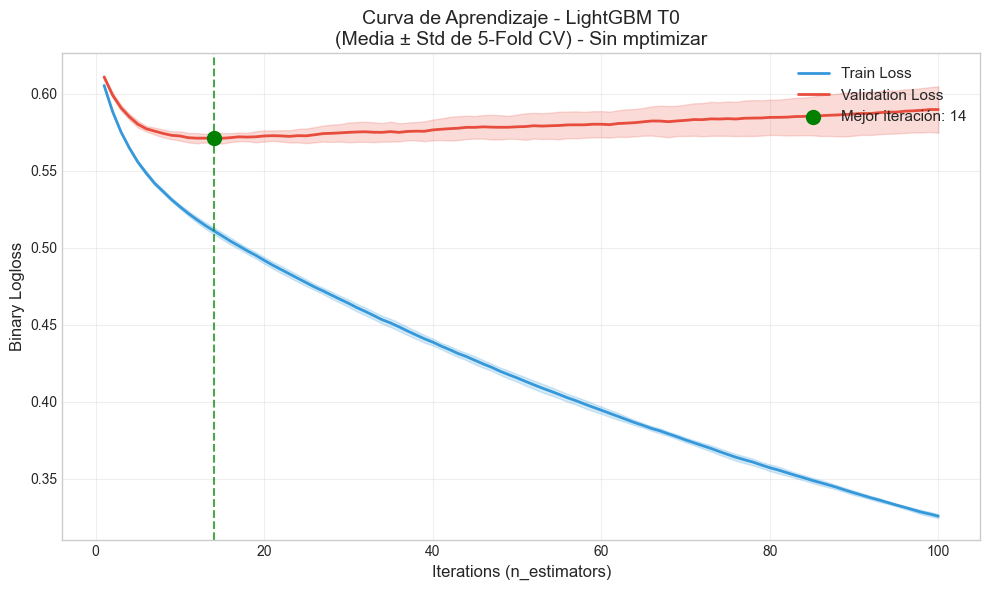


 Resumen:
   Mejor iteración: 14
   Train Loss final: 0.3257
   Val Loss final: 0.5899
   Val Loss mínimo: 0.5712
   Gap (Train - Val): -0.2642

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.8965 | Val: 0.7062
    precision  | Train: 0.7911 | Val: 0.5385
    recall     | Train: 0.9208 | Val: 0.6140
    f1         | Train: 0.8510 | Val: 0.5738
    roc_auc    | Train: 0.9661 | Val: 0.7428

  Fold 2:
    accuracy   | Train: 0.8930 | Val: 0.7006
    precision  | Train: 0.7811 | Val: 0.5331
    recall     | Train: 0.9263 | Val: 0.5658
    f1         | Train: 0.8475 | Val: 0.5489
    roc_auc    | Train: 0.9673 | Val: 0.7420

  Fold 3:
    accuracy   | Train: 0.8930 | Val: 0.7006
    precision  | Train: 0.7808 | Val: 0.5287
    recall     | Train: 0.9275 | Val: 0.6079
    f1         | Train: 0.8478 | Val: 0.5656
    roc_auc    | Train: 0.9684 | Val: 0.7270

  Fold 4:
    accuracy   | Train: 0.8937 | Val: 0.7147
    precision  | Train: 0.7848 | Val: 0.5475
    recall     | Train:

In [27]:
# Entrenar y evaluar T0
results_T0 = entrena_lightgbm(X_train_T0, y_train, fase='T0')

df_resumen_lightgbm = resumen_cv(
    cv_results=results_T0['cv_results'],
    fase='T0',
    modelo='LightGBM'
)
# Guardar tabla de comparación
df_resumen_lightgbm.to_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv", index=False)

print(f"Resultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv")

### Optimización

  OPTIMIZACIÓN LigthGBM CON OPTUNA - FASE T0

Variables: 18
Registros en train: 3539
Trials Optuna: 50
Métrica a optimizar: F1-score (clase Dropout)

scale_pos_weight: 2.11

Proceso de optimización

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation 

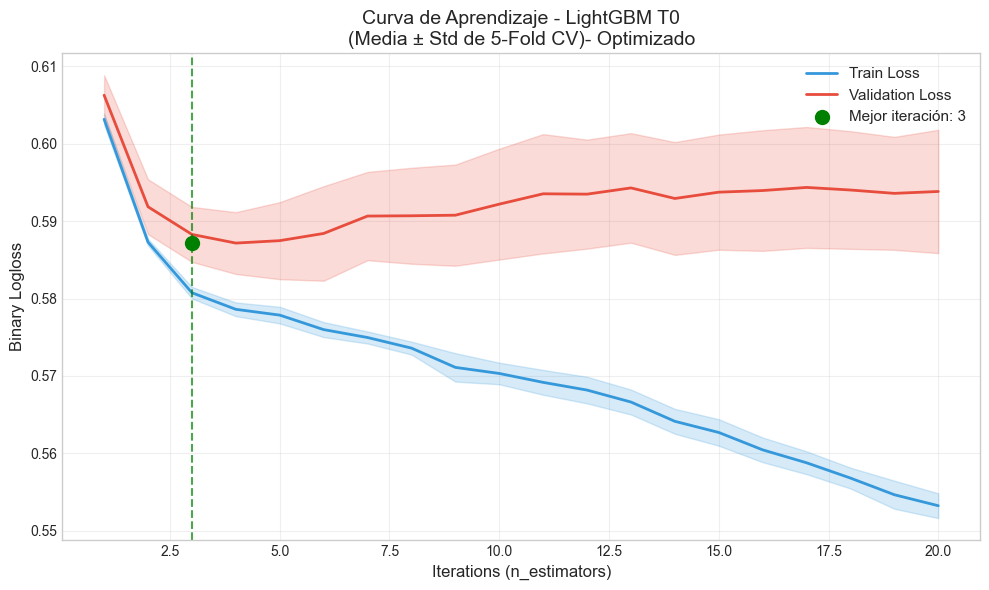


 Resumen:
   Mejor iteración: 3
   Train Loss final: 0.5533
   Val Loss final: 0.5938
   Val Loss mínimo: 0.5872
   Gap (Train - Val): -0.0406

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.7121     0.0051       0.6742     0.0082
   precision          0.5360     0.0060       0.4955     0.0093
   recall             0.7753     0.0058       0.7204     0.0347
   f1                 0.6338     0.0047       0.5867     0.0109****
   roc_auc            0.8076     0.0025       0.7538     0.0028
🏃 View run Optuna_LightGBM_CV5_T0 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/61223be086da443eb7762ceb68835ebe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.5671
  Optuna:   0.5991

Resultados guardados en: ../outputs/models/LightGBM/cv_summary_LightGBM.csv


In [28]:
results_T0_optuna = entrena_lightgbm_con_optuna(X_train_T0, y_train, fase='T0', n_trials=50)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T0['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T0_optuna['best_f1_sore_cv']:.4f}")

df_resumen_lgb_T0_opt = resumen_cv(
    cv_results=results_T0_optuna['cv_results'],
    fase='T0',
    modelo='LightBGM_opt'
)

lgb_path = "../outputs/models/LightGBM/cv_summary_LightGBM.csv"
df_xgb = pd.read_csv(lgb_path)
df_final = pd.concat([df_xgb, df_resumen_lgb_T0_opt], ignore_index=True)
csv_path = "cv_summary_LightGBM.csv"

# Guardar tabla de comparación
df_final.to_csv(lgb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv")

## 7. Modelado FASE T1 (FIN 1ER SEMESTRE)

In [29]:
# Preprocesamiento para T1
X_train_T1, X_test_T1, features_T1, prep_T1 = preprocesamiento_lightgbm(
    X_train, X_test, y_train, fase='T1'
)

print(f"\nT1 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T1.shape}")
print(f"   Test:  {X_test_T1.shape}")
print(f"   Variables: {len(features_T1)}")


T1 - Dimensiones después del preprocesamiento:
   Train: (3539, 29)
   Test:  (885, 29)
   Variables: 29


### Parámetros por defecto

  ENTRENAMIENTO LIGHTGBM - FASE T1

Variables: 29
Registros: 3539

scale_pos_weight: 2.11

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: -1 (sin límite)
   • num_leaves: 31
   • learning_rate: 0.1
   • min_child_samples: 20

Cross-Validation (5-fold):


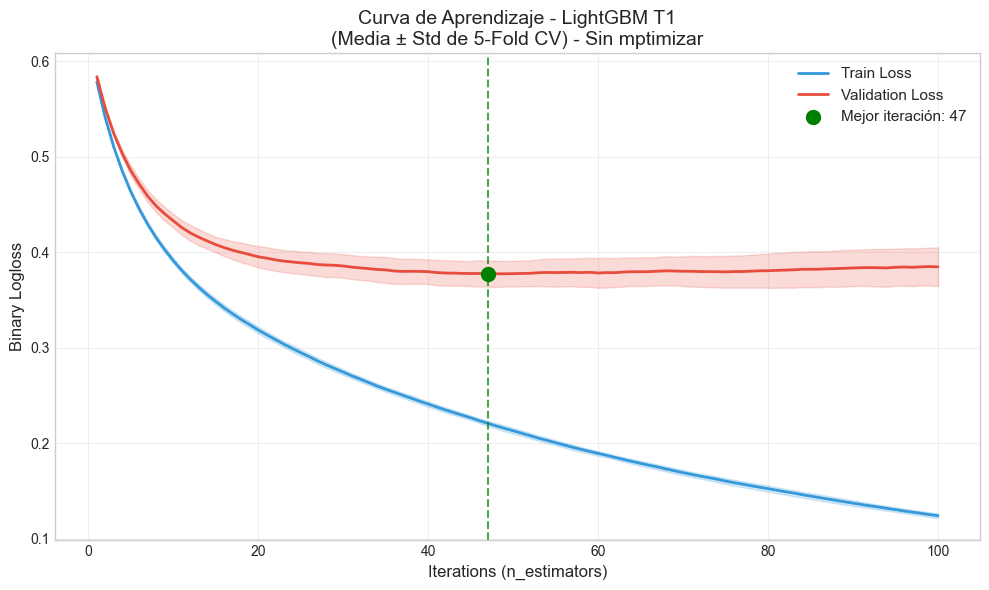


 Resumen:
   Mejor iteración: 47
   Train Loss final: 0.1240
   Val Loss final: 0.3846
   Val Loss mínimo: 0.3773
   Gap (Train - Val): -0.2606

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.9830 | Val: 0.8475
    precision  | Train: 0.9634 | Val: 0.7679
    recall     | Train: 0.9846 | Val: 0.7544
    f1         | Train: 0.9739 | Val: 0.7611
    roc_auc    | Train: 0.9986 | Val: 0.8876

  Fold 2:
    accuracy   | Train: 0.9838 | Val: 0.8263
    precision  | Train: 0.9635 | Val: 0.7512
    recall     | Train: 0.9868 | Val: 0.6886
    f1         | Train: 0.9750 | Val: 0.7185
    roc_auc    | Train: 0.9989 | Val: 0.8735

  Fold 3:
    accuracy   | Train: 0.9848 | Val: 0.8277
    precision  | Train: 0.9676 | Val: 0.7313
    recall     | Train: 0.9857 | Val: 0.7313
    f1         | Train: 0.9766 | Val: 0.7313
    roc_auc    | Train: 0.9989 | Val: 0.8943

  Fold 4:
    accuracy   | Train: 0.9813 | Val: 0.8418
    precision  | Train: 0.9603 | Val: 0.7578
    recall     | Train:

In [30]:
# Entrenar y evaluar T1
results_T1 = entrena_lightgbm(X_train_T1, y_train, fase='T1')

df_resumen_LightGBM_T1 = resumen_cv(
    cv_results=results_T1['cv_results'],
    fase='T1',
    modelo='LightGBM'
)

lb_path = "../outputs/models/LightGBM/cv_summary_LightGBM.csv"
df_lb = pd.read_csv(lb_path)
df_final = pd.concat([df_lb, df_resumen_LightGBM_T1], ignore_index=True)

# Guardar tabla de comparación
df_final.to_csv(lb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv")

### Optimización

  OPTIMIZACIÓN LigthGBM CON OPTUNA - FASE T1

Variables: 29
Registros en train: 3539
Trials Optuna: 50
Métrica a optimizar: F1-score (clase Dropout)

scale_pos_weight: 2.11

Proceso de optimización

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation 

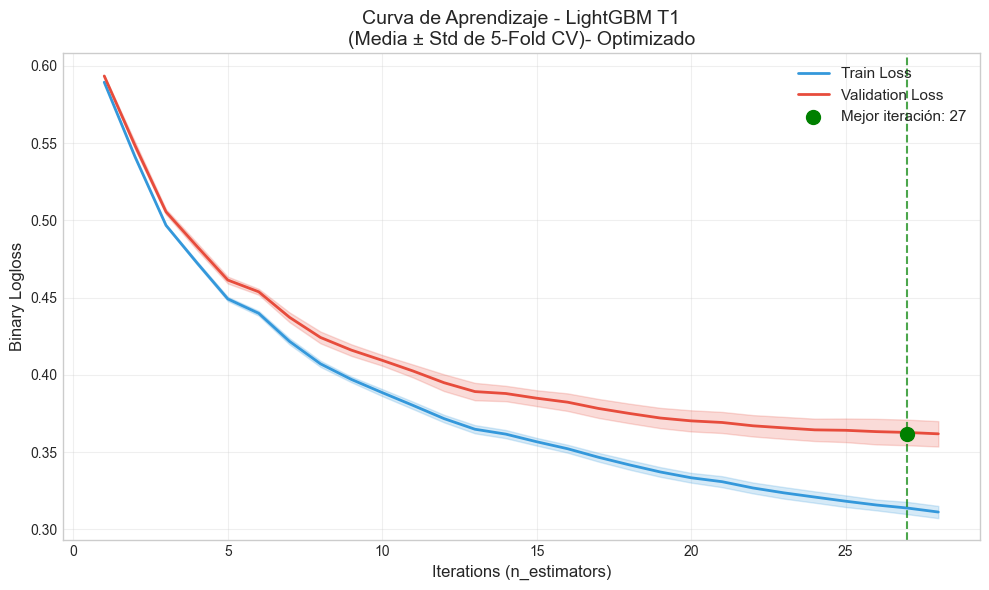


 Resumen:
   Mejor iteración: 27
   Train Loss final: 0.3112
   Val Loss final: 0.3618
   Val Loss mínimo: 0.3618
   Gap (Train - Val): -0.0506

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.8800     0.0034       0.8567     0.0076
   precision          0.8489     0.0053       0.8124     0.0199
   recall             0.7621     0.0077       0.7212     0.0163
   f1                 0.8031     0.0060       0.7639     0.0119****
   roc_auc            0.9346     0.0023       0.8976     0.0101
🏃 View run Optuna_LightGBM_CV5_T1 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/656e1044a9a2475886b062b853c13ad8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7444
  Optuna:   0.7609

Resultados guardados en: ../outputs/models/LightGBM/cv_summary_LightGBM.csv


In [31]:

results_T1_optuna = entrena_lightgbm_con_optuna(X_train_T1, y_train, fase='T1', n_trials=50)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T1['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T1_optuna['best_f1_sore_cv']:.4f}")

df_resumen_lgb_T1_opt = resumen_cv(
    cv_results=results_T1_optuna['cv_results'],
    fase='T1',
    modelo='LightBGM_opt'
)

lgb_path = "../outputs/models/LightGBM/cv_summary_LightGBM.csv"
df_lgb = pd.read_csv(lgb_path)
df_final = pd.concat([df_lgb, df_resumen_lgb_T1_opt], ignore_index=True)
csv_path = "cv_summary_LightGBM.csv"

# Guardar tabla de comparación
df_final.to_csv(lgb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv")

## 8. Modelado FASE T2 (FIN 2DO SEMESTRE)

In [32]:
# Preprocesamiento para T2
X_train_T2, X_test_T2, features_T2, prep_T2 = preprocesamiento_lightgbm(
    X_train, X_test, y_train, fase='T2'
)

print(f"\nT2 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T2.shape}")
print(f"   Test:  {X_test_T2.shape}")
print(f"   Variables: {len(features_T2)}")


T2 - Dimensiones después del preprocesamiento:
   Train: (3539, 35)
   Test:  (885, 35)
   Variables: 35


### Parámetros por defecto

  ENTRENAMIENTO LIGHTGBM - FASE T2

Variables: 35
Registros: 3539

scale_pos_weight: 2.11

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: -1 (sin límite)
   • num_leaves: 31
   • learning_rate: 0.1
   • min_child_samples: 20

Cross-Validation (5-fold):


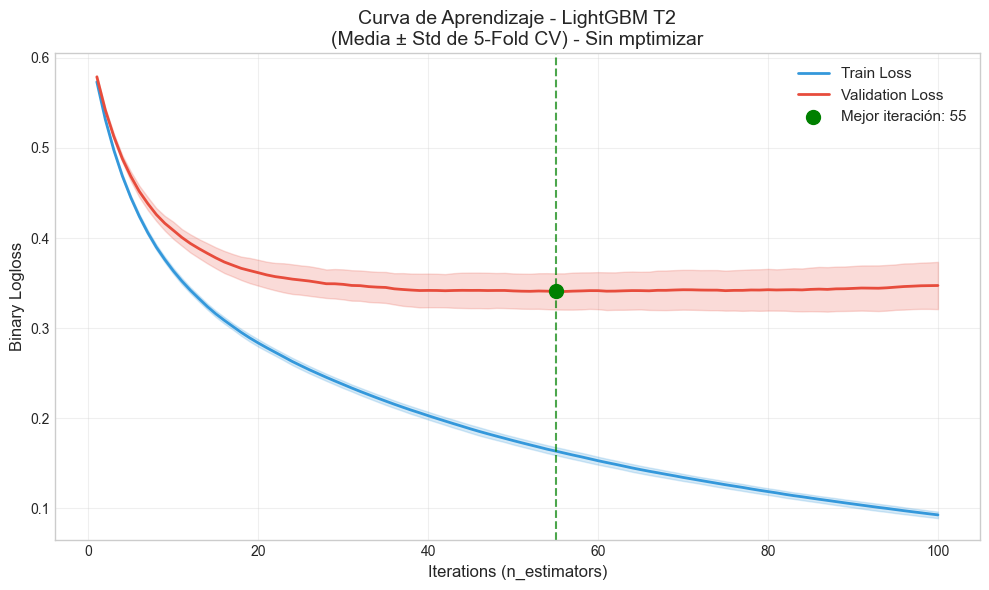


 Resumen:
   Mejor iteración: 55
   Train Loss final: 0.0925
   Val Loss final: 0.3472
   Val Loss mínimo: 0.3406
   Gap (Train - Val): -0.2547

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.9919 | Val: 0.8701
    precision  | Train: 0.9794 | Val: 0.7931
    recall     | Train: 0.9956 | Val: 0.8070
    f1         | Train: 0.9875 | Val: 0.8000
    roc_auc    | Train: 0.9995 | Val: 0.9065

  Fold 2:
    accuracy   | Train: 0.9876 | Val: 0.8517
    precision  | Train: 0.9659 | Val: 0.7709
    recall     | Train: 0.9967 | Val: 0.7675
    f1         | Train: 0.9811 | Val: 0.7692
    roc_auc    | Train: 0.9995 | Val: 0.9079

  Fold 3:
    accuracy   | Train: 0.9926 | Val: 0.8503
    precision  | Train: 0.9826 | Val: 0.7689
    recall     | Train: 0.9945 | Val: 0.7621
    f1         | Train: 0.9885 | Val: 0.7655
    roc_auc    | Train: 0.9997 | Val: 0.9104

  Fold 4:
    accuracy   | Train: 0.9905 | Val: 0.8503
    precision  | Train: 0.9773 | Val: 0.7763
    recall     | Train:

In [33]:
# Entrenar y evaluar T2
results_T2 = entrena_lightgbm(X_train_T2, y_train, fase='T2')

df_resumen_LightGBM_T2 = resumen_cv(
    cv_results=results_T2['cv_results'],
    fase='T2',
    modelo='LightGBM'
)

lb_path = "../outputs/models/LightGBM/cv_summary_LightGBM.csv"
df_lb = pd.read_csv(lb_path)
df_final = pd.concat([df_lb, df_resumen_LightGBM_T2], ignore_index=True)

# Guardar tabla de comparación
df_final.to_csv(lb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv")

### Optimización

  OPTIMIZACIÓN LigthGBM CON OPTUNA - FASE T2

Variables: 35
Registros en train: 3539
Trials Optuna: 50
Métrica a optimizar: F1-score (clase Dropout)

scale_pos_weight: 2.11

Proceso de optimización

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation (5-fold):

Cross-Validation 

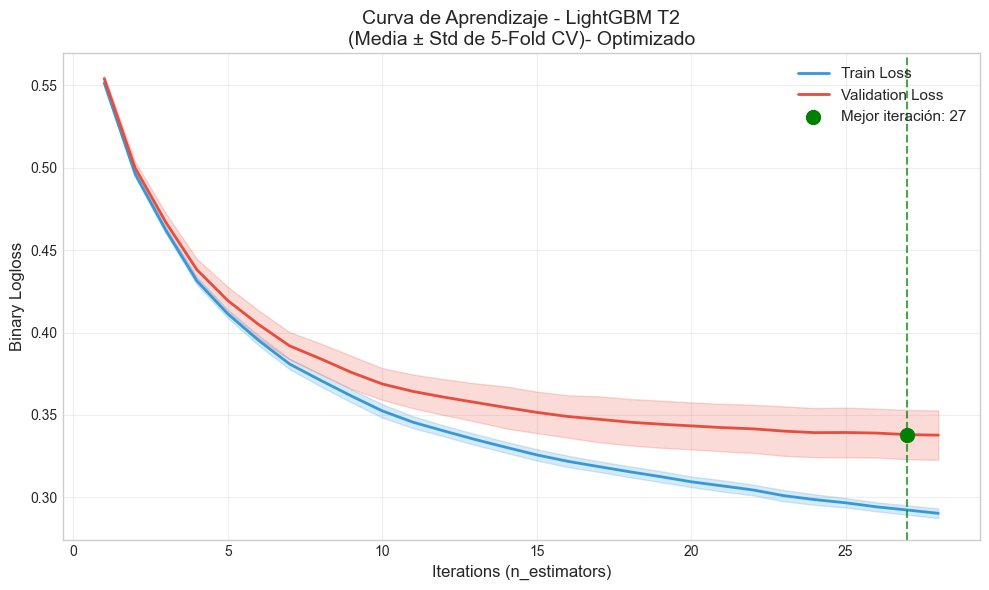


 Resumen:
   Mejor iteración: 27
   Train Loss final: 0.2903
   Val Loss final: 0.3377
   Val Loss mínimo: 0.3377
   Gap (Train - Val): -0.0474

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.8906     0.0022       0.8692     0.0116
   precision          0.8509     0.0058       0.8184     0.0232
   recall             0.7999     0.0091       0.7626     0.0211
   f1                 0.8246     0.0041       0.7893     0.0182****
   roc_auc            0.9434     0.0013       0.9121     0.0098
🏃 View run Optuna_LightGBM_CV5_T2 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/4c5526d349544606a303477c5f16f07b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7444
  Optuna:   0.7609

Resultados guardados en: ../outputs/models/LightGBM/cv_summary_LightGBM.csv


In [34]:
results_T2_optuna = entrena_lightgbm_con_optuna(X_train_T2, y_train, fase='T2', n_trials=50)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T1['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T1_optuna['best_f1_sore_cv']:.4f}")

df_resumen_lgb_T2_opt = resumen_cv(
    cv_results=results_T2_optuna['cv_results'],
    fase='T2',
    modelo='LightBGM_opt'
)

lgb_path = "../outputs/models/LightGBM/cv_summary_LightGBM.csv"
df_lgb = pd.read_csv(lgb_path)
df_final = pd.concat([df_lgb, df_resumen_lgb_T2_opt], ignore_index=True)
csv_path = "cv_summary_LightGBM.csv"

# Guardar tabla de comparación
df_final.to_csv(lgb_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv")


## 9. Resumen Final LightGBM

In [35]:
# Mostrar resumen final
df_final = pd.read_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_LightGBM.csv")

print("================================================================================")
print("  RESUMEN LightGBM - CROSS VALIDATION")
print("================================================================================")
print(df_final.to_string(index=False))

  RESUMEN LightGBM - CROSS VALIDATION
      modelo fase  accuracy_val_mean  accuracy_val_std  precision_val_mean  precision_val_std  recall_val_mean  recall_val_std  f1_val_mean  f1_val_std  roc_auc_val_mean  roc_auc_val_std  accuracy_train_mean  accuracy_train_std  precision_train_mean  precision_train_std  recall_train_mean  recall_train_std  f1_train_mean  f1_train_std  roc_auc_train_mean  roc_auc_train_std
    LightGBM   T0             0.7002            0.0118              0.5296             0.0161           0.6113          0.0251       0.5671      0.0132            0.7389           0.0115               0.8935              0.0017                0.7842               0.0038             0.9222            0.0047         0.8476        0.0023              0.9670             0.0008
LightBGM_opt   T0             0.6742            0.0082              0.4955             0.0093           0.7204          0.0347       0.5867      0.0109            0.7538           0.0028               0.7121   

## 10. Resumen completo de entrenamiento (Todos los algoritmos)

In [36]:
resumen_path = "../outputs/models/cv_summary_entrenamiento.csv"
df_resumen = pd.read_csv(resumen_path)

lb_path = "../outputs/models/LightGBM/cv_summary_LightGBM.csv"
df_lb = pd.read_csv(lb_path)

df_resumen = pd.concat([df_resumen, df_lb], ignore_index=True)

# Guardar tabla de comparación
df_resumen.to_csv(f"../outputs/models/cv_summary_entrenamiento.csv", index=False)

print(f"Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv")

Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv
